# 10 Monkey species

Kacper Olejak, Jakub Pacierpnik

## Introduction.
This notebook provides classifier model for 10 monkey species using [dataset from kaggle](https://www.kaggle.com/slothkong/10-monkey-species).

We created solution based on transfer learning approach, using pretrained VGG16 model for feature extraction and traditional machine learning techniques for image classification.


At the beginning of each piece of our solution, we will explain you our ideas and how we used the tools, mentioned as headings.



## Imports and downloading dataset
Our team decided to use [Keras](https://keras.io/) for Deep Learning stuff and [scikit-learn](https://scikit-learn.org/stable/) which provides some standard Machine Learning methods.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
import os
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
!git clone https://github.com/Qbencjusz/10MonkeySpecies.git

Cloning into '10MonkeySpecies'...
remote: Enumerating objects: 1297, done.
remote: Total 1297 (delta 0), reused 0 (delta 0), pack-reused 1297
Receiving objects: 100% (1297/1297), 500.01 MiB | 37.84 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (1371/1371), done.


## Preprocessing and feature extraction

Our dataset consists of 1098 monkey images for training set and 272 for validation.

This dataset has high resolution photos in .jpg format. It could be hard to use standard preprocessing methods for feature extraction from it.


Firstly, we load our dataset.
Then, transform all images to numpy arrays and preprocessing them, so they can be used as input to our neural network model. 

From now, we want to focus on **transfer learning approach**.

Transfer learning is the process of:
 1. Taking a network pre-trained on a dataset.
 2. And utilizing it to recognize image/object categories it was not trained on.

For our problem, we used transfer learning via feature extraction.

To maximize our results, we choosed [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) neural network model, provided by Keras, with [imagenet weights](http://www.image-net.org/).


VGG16 will be treat as feature extractor as follows:

1. initialize the model with imagenet weights.
2. exlude last layer constisting SoftMax function
3. preprocessed our images from both - training and validation datasets
4. treat output from network as features, which we use to train and validation in our classificators.

![](https://i.imgur.com/Y0ou5sg.png)




In [ ]:
x_train = []
y_train = []

train_path = '10MonkeySpecies/monkeys/training'

for label in os.listdir(train_path):
  for img_path in os.listdir(train_path + '/' + label):
    img = image.load_img(train_path + '/' + label + '/' + img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x_train.append(x)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(1098, 224, 224, 3)
(1098,)


In [ ]:
x_test = []
y_test = []

test_path = '10MonkeySpecies/monkeys/validation'

for label in os.listdir(test_path):
  for img_path in os.listdir(test_path + '/' + label):
    img = image.load_img(test_path + '/' + label + '/' + img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x_test.append(x)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(272, 224, 224, 3)
(272,)


In [ ]:
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
  layer.trainable = False

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
train_features_extractor = vgg_model.predict(x_train)
train_features = train_features_extractor.reshape(train_features_extractor.shape[0], -1)

In [ ]:
test_feature_extractor = vgg_model.predict(x_test)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

In [ ]:
print(train_features_extractor.shape)
print(train_features.shape)

(1098, 7, 7, 512)
(1098, 25088)


## Image classification

The second part of our solution is dedicated to execute three classification methods, which we learned during Machine Learning Course @ ii.uwr.

We want to consider methods listed below:
 1. [Random Forest](https://en.wikipedia.org/wiki/Random_forest)
 2. [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)
 3. [SVM](https://en.wikipedia.org/wiki/Support-vector_machine).

Steps for all classifiers:
  1. train classifier
  2. make a prediction to validation set
  3. compute accuracy
  4. vizualize predictions on heatmap


### Random forest

> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 
[[sklearn]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

This is the only model in our solution, which can be executed as default to multi-class classifition problems, also
random forest is an ensemble method,logistic regression and svm are linear methods.

Random forest achieved 94% accuracy and execution time was quite low.



In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(train_features, y_train_enc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
prediction_rf = rf.predict(test_features)

In [ ]:
print(metrics.accuracy_score(y_test_enc, prediction_rf))

0.9485294117647058


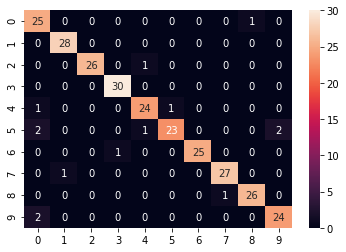

In [ ]:
cm = metrics.confusion_matrix(y_test_enc, prediction_rf)
sns.heatmap(cm, annot=True)

### Logistic Regression

>Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression). [[wikipedia]](https://en.wikipedia.org/wiki/Logistic_regression)

Logistic regression in its default version can be used for binary classifications problems. In our case, we got 10 monkey species, so we used **one versus rest** optimization, where a binary problem is fit for each label.

This model is the winner of our mini-competition.
It's got the same (96%) accuracy as SVM, but computations are exponentially faster.



In [ ]:
lr = LogisticRegression(multi_class='ovr', solver='liblinear')
lr.fit(train_features, y_train_enc)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
prediction_lr = lr.predict(test_features)

In [ ]:
print(metrics.accuracy_score(y_test_enc, prediction_lr))

0.9669117647058824


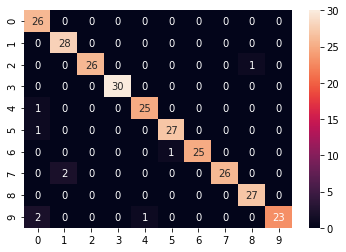

In [ ]:
cm = metrics.confusion_matrix(y_test_enc, prediction_lr)
sns.heatmap(cm, annot=True)

###SVM

> More formally, a support-vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin), since in general the larger the margin, the lower the generalization error of the classifier. [[wikipedia]](https://en.wikipedia.org/wiki/Support-vector_machine#Definition)

SVM is also binary classification on its defaults. Sklearn supports multi-class by using one-vs-one. This strategy splits a multi-class classifiaction into one binary classification problem per each pair of classes. That is probably the reason for high execution time.

On the other hand, model achieved 96% accuracy (the same accuracy as logistic regression).
if we take a look on logistic regression heatmap and SVM heatmap, they misclassify different cases.




In [ ]:
svm = SVC(C=1.0, kernel='linear')
svm.fit(train_features, y_train_enc)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
prediction_svm = svm.predict(test_features)

In [ ]:
print(metrics.accuracy_score(y_test_enc, prediction_svm))

0.9669117647058824


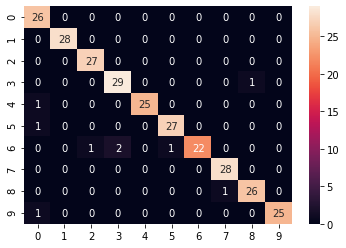

In [ ]:
cm = metrics.confusion_matrix(y_test_enc, prediction_svm)
sns.heatmap(cm, annot=True)

### Bonus: Feature visualization of the monkey at first layer of VGG16.

We were wondering, how the VGG16 model activates its filters in some layers to images. We picked a monkey image and visualize activation on it in the first layer of the model.


In [ ]:
# based on: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

def feature_map(img_name, model):

    # extracting VGG16 with layer
    model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    
    # load image, plot it and convert
    label = img_name[:2]
    img=image.load_img(f"10MonkeySpecies/monkeys/training/{label}/{img_name}", target_size=(224,224))
    plt.imshow(img)
    plt.show()
    plt.close()
    img = image.img_to_array(img)

    # expand dimensions so that it represents a single 'sample'
    img = np.expand_dims(img, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)
    img = preprocess_input(img)
    # get feature map for first hidden layer
    feature_maps = model.predict(img)
    # plot the output from each block
    square = 8
    # plot all 64 maps in an 8x8 squares
    ix = 1
    plt.figure(figsize=(15,15))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix-1])
            ix += 1
    # show the figure
    plt.show()
    plt.close()
    

As the result of applying the first layer onto the monkey, we ended up with 64 feature activation images.

Some images highlight contours, other focus on the background, some of them also activate on the face of a monkey.

If we go deeper into the model, the feature maps show less and less details for human eye, but more details for better detection.

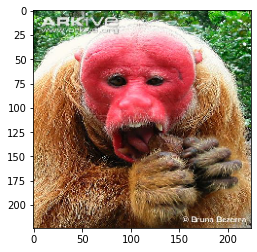

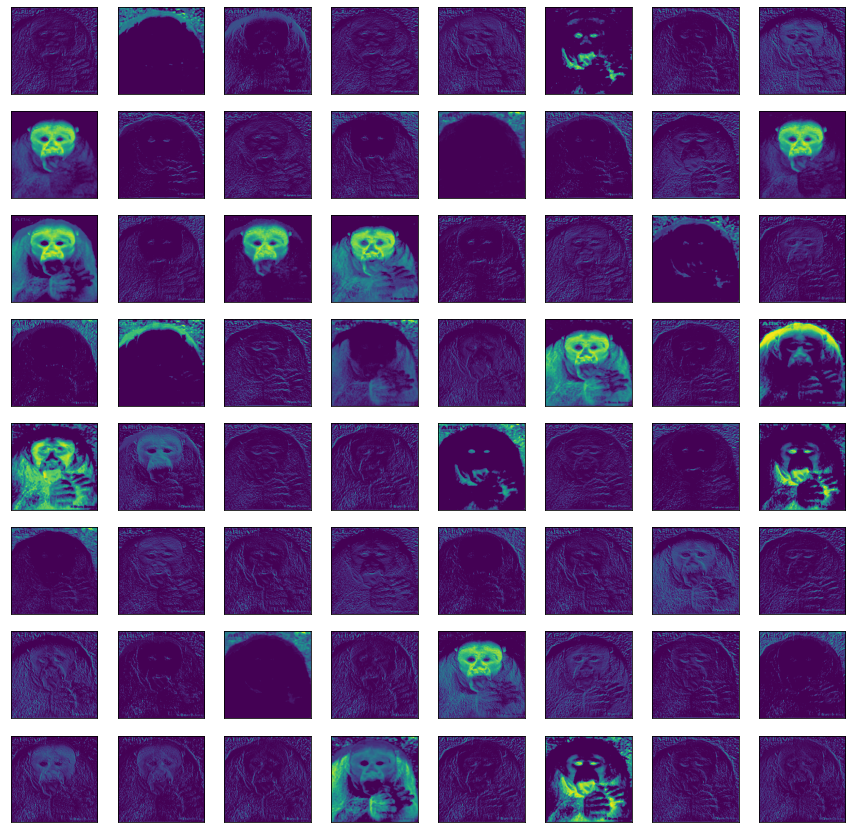

In [ ]:
feature_map("n2127.jpg",vgg_model)